# Linear Elasticity

This example can be found in Section 5.2 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

## 1. Problem statement

Given a series of experimental observations, obtained from a material specimen undergoing uniaxial tension - for example, stress-strain data - and acknowledging that the observations will be contaminated by a small amount of noise, infer the model parameters that describe the material response with a quantified level of uncertainty.

<span style="color: blue;">
    
We are given a series of experimental observations in the form of stress-strain ($\sigma$-$\epsilon$) data, obtained from a uniaxial tensile test of a linear-elastic material specimen. All observations are contaminated by a degree of noise, and it is essential to acknowledge and mitigate this noise to ensure the accuracy of any subsequent analyses or conclusions drawn from the data. 

</span>

![](figures/linear-elastic-experimental-observations.png)

<span style="color: blue;">

#### General problem statement

Given a set of observed realisations of a random variable $X$,

$$S = \{x_1, x_2, ..., x_N\}, \quad x_j \in \mathbb{R}^n$$
 
we aim to infer the underlying probability distributions that generate the data set $S$.

</span>

## 2. Material model
<!-- 
An expert, upon examining the above experimental observations, could reasonably assume that the  material response is best described by a linear elastic model.

It is assumed that the behaviour of the material specimen can be described by a linear elastic law that is defined by a single parameter: Young's modulus $E$. The stress-strain response of the linear elastic model during uniaxial tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon$$

where $\sigma$ denotes the stress, $\epsilon$ the strain, $\textbf{x}$ the model parameter vector (here $\textbf{x} = E$) and $E$ the Young's modulus. 
 -->
Upon examining the above experimental observations, an expert could reasonably infer that the material response is best characterised by a linear elastic model. The behaviour of a linear elastic material is described by a single parameter, Young's modulus $E$, and the stress-strain relationship in a linear elastic material during uniaxial tension can be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon$$

where $\sigma$ represents stress, $\epsilon$ represents strain, $\textbf{x}$ denotes the model parameter vector (in this case, $\textbf{x} = E$), and $E$ denotes Young's modulus. Below is a `LinearElastic` class...

![](figures/linear-elastic-material-model.png)

In [2]:
def compute_stress(E, strain):
    """
    Linear elastic material
    """
    return E * strain

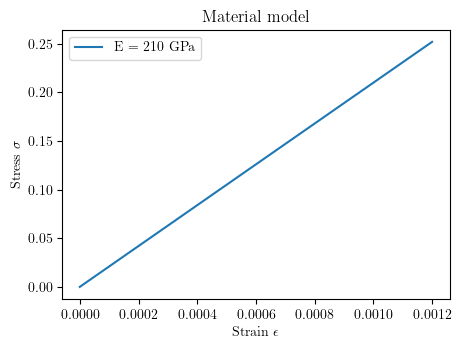

In [3]:
E = 210
strain = np.linspace(0, 1.2e-3, 100)
stress = compute_stress(E, strain)

plt.figure(figsize=(5, 3.5))
plt.plot(strain, stress, label=f"E = {E} GPa")
plt.title("Material model")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
plt.savefig("figures/linear-elastic-material-model.png", dpi=300)

## 3. Model fitting and inverse problems

The problem statement is an example of an **inverse problem**. The goal of an inverse problem is to estimate an unknown parameter that is not directly observable by using measured data and a mathematical model linking the observed and the unknown.

Central to this process is **model fitting**, where a mathematical model is selected or designed to describe the relationship between observed data and the unknown parameter. This model is adjusted to minimise the disparity between predicted values and actual observations, typically employing optimisation techniques to find the best-fitting parameters. Through model fitting, predictions or estimations about the unknown parameter can be derived.

#### Conventional methods

Linear regression or optimisation techniques are typically employed to address inverse problems. Let us consider a scenario where we have a dataset comprising observed data points and a mathematical model that links these observations to the unknown parameter we aim to estimate. Linear regression, for instance, seeks to establish a linear relationship between the observed data and the unknown parameter. This involves minimising the squared differences between the observed data points and the corresponding predictions made by the model.

However, traditional methods like linear regression have certain limitations when dealing with inverse problems:

1. **Assumptions about linearity:** Linear regression assumes that the relationship between the observed data and the unknown parameter is linear. In many real-world scenarios, this assumption may not hold true, leading to biased estimates.

2. **Overfitting:** Conventional methods may overfit the data, particularly when dealing with high-dimensional datasets or when the model is overly complex relative to the available data. Overfitting can result in poor generalisation performance and unreliable estimates of the unknown parameter.

3. **Uncertainty quantification:** Linear regression typically does not provide a straightforward means to quantify uncertainty in the estimated parameters. It offers **point estimates** without adequately capturing the inherent uncertainty in the data or the model assumptions.

#### Bayesian inference

A Bayesian framework offers significant advantages. In Bayesian inference, we treat the unknown parameter as a random variable and specify a prior distribution representing our initial beliefs or knowledge about the parameter before observing the data. By combining this prior distribution with the likelihood function (which describes how the data are generated given the parameter values) and applying Bayes' theorem, we can derive the posterior distribution, reflecting our updated beliefs about the parameter after observing the data.

There are multiple reasons why a Bayesian framework is better suited for solving inverse problems:

1. **Incorporating prior knowledge:** Bayesian inference enables us to incorporate prior knowledge or beliefs about the unknown parameter into the estimation process. This proves particularly useful when dealing with limited data, as it helps regularise the estimation and reduces the risk of overfitting.

2. **Flexibility in modelling:** Unlike traditional methods, which often rely on specific assumptions about the data-generating process (e.g. linearity in linear regression), Bayesian inference provides a flexible framework for modelling complex relationships and incorporating various sources of uncertainty.

3. **Uncertainty quantification:** Bayesian inference naturally provides a means to quantify uncertainty in the estimated parameters through the posterior distribution. This allows for more informed decision-making by accounting for the inherent uncertainty in the data and the model.

Overall, the Bayesian framework offers a principled approach to solving inverse problems by integrating prior knowledge, capturing uncertainty, and providing more robust and interpretable estimates compared to traditional methods like linear regression.

In [4]:
def linear_regression(x, y):
    """
    Linear regression - direct least squares regression

    y = mx + c

    Parameters
    ----------
    x : float
        Independent variable

    y : float
        Dependent variable

    Returns
    -------
    m : float
        Gradient

    c : float
        Intercept

    Notes
    -----
    https://pythonnumericalmethods.berkeley.edu/notebooks/chapter16.04-Least-Squares-Regression-in-Python.html
    """
    A = np.vstack([x, np.ones(len(x))]).T
    y = y[:, np.newaxis]
    return np.dot((np.dot(np.linalg.inv(np.dot(A.T, A)), A.T)), y)

In [5]:
class BaseModel:
    """
    Base class for models used in Bayesian inference.

    Subclasses must implement the __call__ method.
    """

    def __call__(self, *args, **kwargs):
        """
        Define the behaviour of the model.

        Parameters
        ----------
        *args : tuple
            Positional arguments.

        **kwargs : dict
            Keyword arguments.

        Returns
        -------
        Any
            The output of the model.
        """
        raise NotImplementedError("Subclasses must implement __call__ method.")


class LinearElastic(BaseModel):
    """
    Linear elastic material model

    Attributes:
    -----------
    x_observed : float
        The observed value of the independent variable.
    """

    def __init__(self, x_observed):
        """
        Parameters
        ----------
        x_observed : float
            The observed value of the independent variable.
        """
        self.x_observed = x_observed

    def __call__(self, parameters):
        """
        Compute stress based on the provided parameters.

        Parameters
        ----------
        parameters : tuple or list
            Model parameters. For a linear elastic model, it should contain
            only one parameter representing the Young's Modulus.

        Returns
        -------
        stress : float
            Computed stress.
        """
        # if len(parameters) != 1:
        #     raise ValueError("LinearElastic model expects exactly one parameter.")
        
        return parameters * self.x_observed

## 4. Generating synthetic data

In order to introduce the Bayesian approach in the most intuitive manner, the experimental observations are generated numerically so that they deviate from the *true* constitutive model using a known noise model. This allows for a one-to-one comparison between the *true* parameter values and the inferred parameter distributions.

### *True* material parameters

The *true* value of $E$ that we are attempting to identify (infer) from the experimental observations is:

$$E = 210 \; \textrm{GPa}$$

The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$. Note that in this case, only the stress measurement is contaminated by noise. 

$$\Omega = \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(0, 0.01^2)$$

The *true* stress-strain response and the noisy experimental observations are illustrated in the following figure.

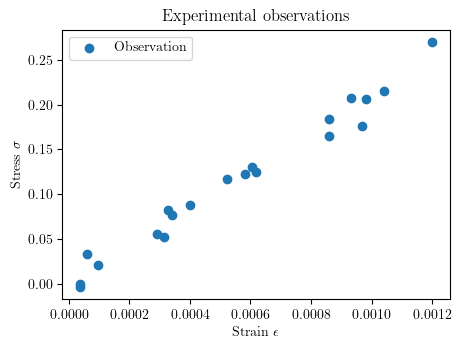

In [6]:
sigma = 0.01  # standard deviation of the noise
n_observations = 20
x = np.linspace(0, 1.2e-3, 100)
strain_observed = np.random.choice(x, n_observations)
stress_observed = compute_stress(E, strain_observed) + np.random.normal(scale=sigma, size=strain_observed.shape[0]) # noisy data

plt.figure(figsize=(5, 3.5))
plt.scatter(strain_observed, stress_observed, label='Observation')
plt.title("Experimental observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
# plt.savefig("figures/linear-elastic-experimental-observations.png", dpi=300)

## 5. Bayesian inference

Now it is time to introduce Bayes' Theorem.

We have some noisy experimental data from a uniaxial tensile test of a material specimen. Using our expert judgement we have hypothesised that the material response can be described by a linear-elastic material law. We now wish to identify (infer) the model parameters from the experimental observations. 

The most commonly used approach to identify model parameters is to formulate an error function that measures the difference between the model response and the experimental data. The error function is then minimised with respect to the model parameters in order to determine the most suitable values (linear regression etc). This approach provides a deterministic estimate of model parameters, and is unable to account for the unavoidable uncertainties associated with determining parameters from noisy experimental data.

The Bayesian approach enables a rigorous treatment of all sources of uncertainy, for example, noise in the experimental observations and model uncertainty (uncertainty due to assumptions and simpliciations made in the physical model). The model and model parameters that explain an observed data set are treated as uncertain variables, as opposed to deterministic variables. Bayesian inference provides a framework to learn the entire distribution of model parameters, not just deterministic estimates, which maximize the probability of observing the given data. Learning comes from two sources: (1) the evidence provided by the observed data, and (2) domain knowledge from experts (i.e. prior knowledge).

<span style="color: blue;">
    
### Bayesian Inference

#### Introduction
- Brief overview of Bayesian inference as a statistical method.
- Highlight its relevance and widespread application in various fields, including but not limited to machine learning, economics, and biology.

#### Fundamental Concepts

1. **Bayes' Theorem:**
   - Explanation of Bayes' theorem and its significance in updating beliefs based on evidence.
   - Mathematical formulation and its interpretation.
2. **Prior Probability:**
   - Definition and explanation of prior probability.
   - Discussion on how prior knowledge or beliefs are incorporated into Bayesian inference.
3. **Likelihood Function:**
   - Definition and explanation of the likelihood function.
   - Role of the likelihood function in quantifying the support that the observed data provides for different values of the parameters.
4. **Posterior Probability:**
   - Definition and explanation of posterior probability.
   - Derivation of the posterior distribution using Bayes' theorem.
   - Importance of the posterior distribution as the updated probability distribution of the parameters after considering the observed data.

#### Bayesian Inference Process
1. **Model Specification:**
   - Explanation of the process of defining a probabilistic model that describes the relationship between the observed data and the unknown parameters.
2. **Prior Selection:**
   - Discussion on choosing appropriate prior distributions based on prior knowledge or assumptions about the parameters.
3. **Likelihood Evaluation:**
   - Explanation of how the likelihood function is evaluated based on the observed data and the chosen model.
4. **Posterior Inference:**
   - Description of methods for obtaining the posterior distribution, including analytical, numerical, and computational techniques such as Markov Chain Monte Carlo (MCMC) methods.

#### Interpretation and Applications
- Interpretation of the posterior distribution in Bayesian inference.
- Illustration of Bayesian inference through examples from various domains, showcasing its flexibility and usefulness in practical scenarios.

#### Strengths and Limitations
- Discussion on the strengths of Bayesian inference, including its ability to incorporate prior knowledge, provide coherent uncertainty quantification, and handle complex models.
- Examination of the limitations and challenges associated with Bayesian inference, such as computational complexity, sensitivity to prior specification, and the subjectivity involved in choosing priors.

#### Conclusion
- Recap of the key concepts and processes involved in Bayesian inference.
- Emphasis on its importance as a powerful statistical framework for inference and decision-making.

</span>

### 5.1 Bayes' theorem

Baye's theorem is used to determine the probability of a hypothesis given observed evidence (the posterior probability). In this example, we can think of the hypothesis and evidence as follows:

- **Hypothesis:** we hypothesise a model and values for the model parameters, and then we assess how well the model parameters explain the observations
- **Evidence:** the evidence is in the form of experimental observations (stress-strain data from a uniaxial tensile test)

The posterior probability is a function of the prior probability (prior knowledge) and a "likelihood function" derived from a statistical model for the observed data. Bayesian inference computes the posterior probability according to Bayes' theorem:

$$\pi(\textbf{x}|\textbf{y}) = \frac{\pi(\textbf{x})\pi(\textbf{y}|\textbf{x})}{\pi(\textbf{y})}$$

where $\pi(\textbf{x}|\textbf{y})$ is the posterior probability, $\pi(\textbf{x})$ is the prior probability, $\pi(\textbf{y}|\textbf{x})$ is the likelihood and $\textbf{x}$ denotes a vector with $n_p$ model parameters and $\textbf{y}$ denotes a vector with $n_m$ observations.

### 5.2 Prior $\pi(\textbf{x})$

The prior encapsulates the initial belief regarding the value of a parameter before considering any evidence. The prior can be established through consulting experts or examining existing literature, for example, to determine a typical value for material stiffness. In our case, the sole unknown parameter is the material stiffness $E$, and we adopt a prior represented by a modified normal distribution:

$$\pi(E) \propto exp\left(-\frac{(E - \overline{E})^2}{2s^2_E}\right) \quad \text{if}\; E \geqslant 0$$

This distribution is chosen to reflect the constraint that material stiffness cannot be negative or zero. The parameter $\overline{E}$ denotes the mean stiffness value, while $s_E$ represents the standard deviation. Utilising this prior distribution enables us to incorporate our understanding of material properties into the analysis, providing a foundation for making informed inferences about $E$. This concept is very powerful when we only have a small data set.

In [7]:
class Prior:
    
    def __init__(self, mu=0, sigma=1):
        """
        Initialise the normal prior distribution.

        Parameters
        ----------
        mu : float, optional
            Mean of the normal distribution. Default is 0.
            
        sigma : float, optional
            Standard deviation of the normal distribution. Default is 1.
        """
        self.mu = mu
        self.sigma = sigma

    def evaluate(self, x):
        """
        Evaluate the prior function at the given value(s) of x.

        Parameters
        ----------
        x : float or array-like
            The value(s) at which to evaluate the prior function.

        Returns
        -------
        float or array-like
            The prior probability density at the given value(s).
        """
        return scipy.stats.norm.pdf(x, loc=self.mu, scale=self.sigma)

    def plot(self, x_values):
        """
        Plot the prior function over a range of x values.

        Parameters
        ----------
        x_values : array-like
            The range of x values for plotting.
        """
        prior_values = self.evaluate(x_values)

        plt.plot(x_values, prior_values, label='Normal Prior')
        plt.xlabel('x')
        plt.ylabel('Prior Probability Density')
        plt.title('Prior Function with Normal Distribution')
        plt.legend()
        plt.grid(True)
        plt.show()

### 5.4 Likelihood $\pi(\textbf{y}|\textbf{x})$

The likelihood function represents the probability that the observed data $\textbf{y}$ was generated by the model parameters $\textbf{x}$. Thus, when evaluated on a given sample of the model parameters $\textbf{x}$, the likelihood function indicates which parameter values are more likely than others, in the sense that they would have made the observed data $\textbf{y}$ more probable. A low value of likelihood would indicate that either the model is wrong, the model parameters are wrong, or the observed data is rare. To construct the likelihood function we need to define a model that represents the data-generating process.

#### Statistical generating model 

We define a statistical model that represents the data-generating process (i.e. a model of our experimental data).

$$\textbf{y} = \textbf{f}(\textbf{x}) + \mathbf{\Omega}$$

where $\textbf{y}$ denotes a vector with $n_m$ experimental observations, $\textbf{x}$ denotes a vector with $n_p$ unknown model parameters, and $\mathbf{\Omega}$ is the noise in the experimental observations. We assume that the noise distribution is known (including its parameters). $\textbf{f}(\textbf{x})$ denotes the model and is a function of the unknown model parameters $\textbf{x}$. For this case the only unknown parameter is the material stiffness $E$. The likelihood function is formulated as follows:

$$\pi(\textbf{y}|\textbf{x}) = \pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x}))$$

The only unknown material parameter in the linear elastic model is the Young's modulus ($E$) and based on the above, the additive noise model for a single stress measurement can be written as follows:

$$y = E\epsilon + \Omega$$

where $y$ denotes the measured stress and $\Omega$ denotes the random variable representing the noise in the stress measurement. We consider the noise distribution to be normal (Gaussian) and hence, the likelihood function for a single observation can be expressed as:

$$\pi(y|E) = \pi_{noise}(y - E\epsilon) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{(y - E\epsilon)^2}{s^2_{noise}}}\right)$$

The likelihood for all observations can be expressed as:

$$\pi(\textbf{y}|E) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{\sum_{i=1}^{n_m}(y - E\epsilon)^2}{s^2_{noise}}}\right)$$

In [8]:
class Likelihood:

    def __init__(self, y, sigma, model):
        """
        y : ndarray
            Observed data
        """
        self.y = y
        self.sigma = sigma
        self.model = model

    def evaluate(self, x):
        """
        x : float or array-like
            The value(s) of the model parameters.
        """
        residual = self._compute_residual(x)
        return 1 / (self.sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (residual ** 2 / self.sigma))

    def _compute_residual(self, x):
        return np.sum(self.y - self.model(x))

### 5.5 Posterior $\pi(E|y)$

The PDF of the unknown parameters $\textbf{x}$, given the observations $\textbf{y}$

The posterior distribution for a single stress measurement reads:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi(\textbf{y}|\textbf{x})$$

$$\pi(E|y) \propto exp\left(-\left[\frac{(E - \overline{E})^2}{2s^2_E} + \frac{(y-E\epsilon)^2} {2s^2_{noise}}\right]\right) \quad \text{if}\; E \geqslant 0$$

Since the data $y$ is already measured, the denominator in Bayes' Theorem $\pi(y)$ is a positive constant number $C$. This constant number can be regarded as a normalisation factor that ensures that the integral of the posterior $\pi(E|y)$ over $E$ equals 1:

$$\pi(E|y) = \frac{1}{C}\pi(E)\pi(y|E)$$

In [9]:
class Posterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.prior.evaluate(x) * self.likelihood.evaluate(x)

## 6. Compute the Posterior Distribution

Bayesian inference allows us to update our beliefs about parameters of interest given observed data. This updating process results in the posterior distribution, which encapsulates our updated knowledge about the parameters after considering the data. Several methods can be employed to compute the posterior distribution. <span style="color: blue;">Below we describe the three most popular methods:</span>

#### Analytical Solution:

The analytical solution involves deriving the posterior distribution mathematically by applying Bayes' theorem. Given prior beliefs about the parameters and the likelihood function representing the probability of observing the data given the parameters, Bayes' theorem provides a formula for updating these beliefs to obtain the posterior distribution. This method is ideal when both the prior and likelihood functions have conjugate distributions, leading to a closed-form solution. Examples include the normal-normal and beta-binomial models.

<span style="color: blue;">

It is possible to analytically examine the posterior distribution for a linear elastic model if the noise model is additive and the noise distribution and the prior distribution are (modified) normal distributions.

</span>

#### Grid Search:

In cases where analytical solutions are not feasible due to complex or non-standard distributions, grid search provides a practical numerical approach. In grid search, the parameter space is discretized into a grid, and the posterior probability is computed for each grid point. This method involves evaluating the prior and likelihood functions at each grid point and then normalizing to obtain the posterior probabilities. While grid search is straightforward to implement, it may become computationally intensive for high-dimensional parameter spaces.

#### Markov Chain Monte Carlo (MCMC):

MCMC methods offer a powerful and versatile approach to estimate the posterior distribution, particularly in high-dimensional and complex models where analytical solutions or grid search are impractical. MCMC algorithms, such as Metropolis-Hastings and Gibbs sampling, generate a Markov chain that asymptotically converges to samples from the target posterior distribution. These methods iteratively propose candidate parameter values, accepting or rejecting them based on a defined acceptance criterion that preserves the desired distribution. MCMC provides flexibility in handling complex models and can efficiently explore the parameter space, even in cases of high dimensionality or non-standard distributions.

Each of these methods has its strengths and limitations, and the choice depends on factors such as the complexity of the model, computational resources available, and the desired accuracy of the posterior estimation. Additionally, combining multiple approaches or employing advanced MCMC techniques, such as Hamiltonian Monte Carlo, can further enhance the accuracy and efficiency of Bayesian inference in various scenarios.

In [10]:
def grid_search(posterior, parameter_candidates):
    """
    Search every possible candidate
    """
    pdf = []
    for candidate in parameter_candidates:
        pdf.append(posterior.evaluate(candidate))
    return pdf

### Compute the posterior: 2 observations (small data set)

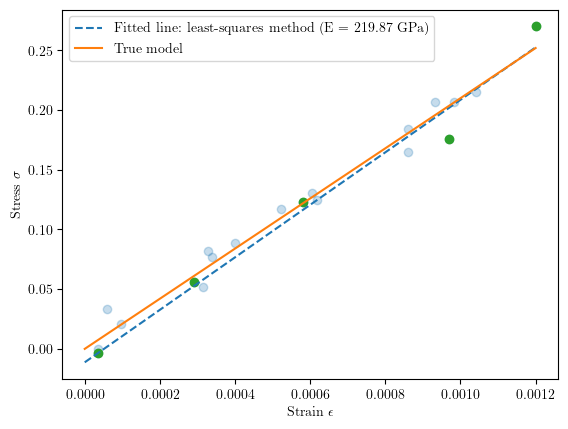

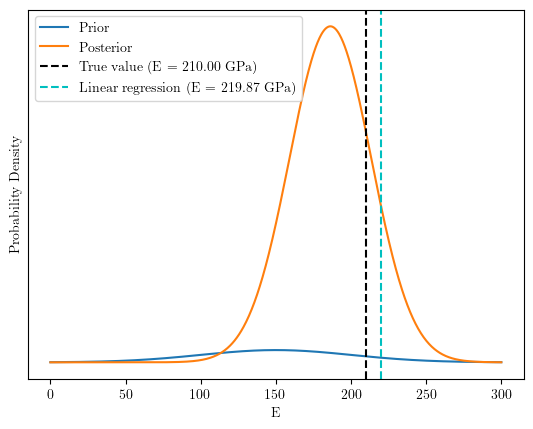

In [11]:
subset = np.random.randint(len(strain_observed), size=5)

model = LinearElastic(strain_observed[subset])
prior = Prior(150, 50)
likelihood = Likelihood(stress_observed[subset], 0.01, model)
posterior = Posterior(prior, likelihood)

pdf = grid_search(posterior, np.linspace(0, 300, 1000)) # posterior.evaluate(np.linspace(0, 300, 1000))
m, c = linear_regression(strain_observed[subset], stress_observed[subset])

plt.figure()
plt.plot(strain, (m * strain) + c, "--", color="C0", label="Fitted line: least-squares method (E = {:.2f} GPa)".format(m.item()))
plt.plot(strain, E * strain, color="C1", label="True model")
plt.scatter(strain_observed, stress_observed, alpha=0.25)
plt.scatter(strain_observed[subset], stress_observed[subset], color="C2")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()

plt.figure()
plt.plot(np.linspace(0, 300, 1000), prior.evaluate(np.linspace(0, 300, 1000)), label='Prior')
plt.plot(np.linspace(0, 300, 1000), pdf, label='Posterior')
plt.axvline(x=210, label="True value (E = {:.2f} GPa)".format(210), linestyle="--", color="k")
plt.axvline(x=m, label="Linear regression (E = {:.2f} GPa)".format(m.item()), linestyle="--", color="c")
plt.xlabel("E")
plt.ylabel("Probability Density")
plt.yticks([])
plt.legend()

### Compute the posterior: 10 observations (large data set)

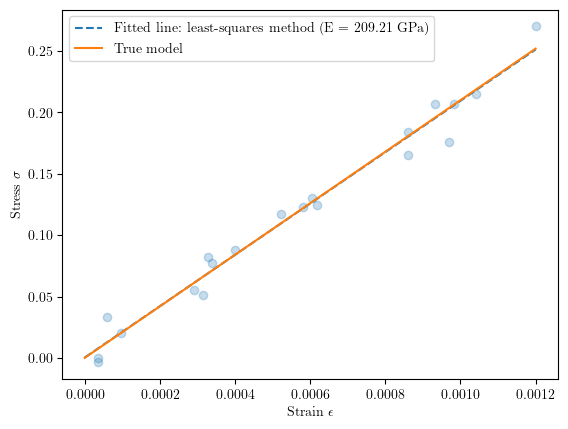

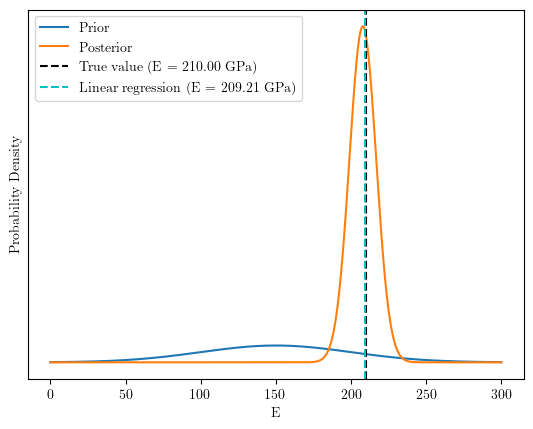

In [12]:
model = LinearElastic(strain_observed)
prior = Prior(150, 50)
likelihood = Likelihood(stress_observed, 0.01, model)
posterior = Posterior(prior, likelihood)

pdf = grid_search(posterior, np.linspace(0, 300, 1000))
m, c = linear_regression(strain_observed, stress_observed)

plt.figure()
plt.plot(strain, (m * strain) + c, "--", color="C0", label="Fitted line: least-squares method (E = {:.2f} GPa)".format(m.item()))
plt.plot(strain, E * strain, color="C1", label="True model")
plt.scatter(strain_observed, stress_observed, alpha=0.25)
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()

plt.figure()
plt.plot(np.linspace(0, 300, 1000), prior.evaluate(np.linspace(0, 300, 1000)), label='Prior')
plt.plot(np.linspace(0, 300, 1000), pdf, label='Posterior')
plt.axvline(x=210, label="True value (E = {:.2f} GPa)".format(210), linestyle="--", color="k")
plt.axvline(x=m, label="Linear regression (E = {:.2f} GPa)".format(m.item()), linestyle="--", color="c")
plt.xlabel("E")
plt.ylabel("Probability Density")
plt.yticks([])
plt.legend()

### Why are density values omitted?

When plotting the posterior density in Bayesian statistics, it is customary not to include density values on the y-axis of the plot. Instead, the y-axis typically represents the relative probability or density of different parameter values given the observed data.

There are several reasons for omitting density values:

1. **Relative comparison**: The principal objective of a posterior density plot is to visualise the distribution's shape and understand the relative likelihoods of different parameter values. Including density values on the y-axis would not significantly enhance interpretation, as the focus lies on the distribution's shape and how it varies across parameter values.

2. **Normalization**: Posterior densities are often scaled so that the area under the curve equals 1. Including density values on the y-axis would necessitate selecting a scale that may not be immediately intuitive and could detract from the primary purpose of the plot.

3. **Interpretability**: Posterior densities are frequently interpreted in a relative sense rather than in terms of absolute density values. For instance, a higher peak in the posterior density indicates that a particular parameter value is more probable given the observed data, but the actual density value at that point may lack direct interpretation.

4. **Focus on shape**: Excluding density values facilitates focusing on the distribution's shape and visually comparing different parameter values. This aids in comprehending the uncertainty associated with parameter estimation and identifying regions of high probability.

In summary, the absence of density values on the y-axis of posterior density plots helps maintain clarity and focus on the relative likelihoods of different parameter values, which is typically the primary objective when visualising posterior distributions in Bayesian analysis.

## X. Metropolis-Hastings

Once the posterior is constructed, it needs to be analysed to determine the statistical summaries. For the linear elastic case, the statistical summaries were establised analytically and by employing a grid search method (i.e.  exhaustively searching through a specified subset of the parameter space).

When the search space becomes larger, or the model is expensive to evaluate, it can become infeasible to do an exhaustive search and we must turn to randomised searches (Monte Carlo methods etc). There are many libraries for searching the posterior but we will implement a [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler to help develop undersanding. Note that I stole the code for the sampler from this [blog](https://colindcarroll.com/2018/11/24/animated-mcmc-with-matplotlib/) by Colin Carroll.

In the next [example](02-linear-elasticity-perfect.ipynb) we will write a `Sampler` class 

**Adaptive Metropolis-Hastings**

In [13]:
def mh_sampler(posterior, steps=3000, step_size=5, init=0):
    """
    Metropolis-Hastings sampler with a normal proposal
    """
    point = init
    samples = []
    pdf = []
    for _ in range(int(steps)):
        proposal = np.random.normal(point, step_size)
        if np.random.rand() < posterior.evaluate(proposal) / posterior.evaluate(point):
            point = proposal
        samples.append(point)
        pdf.append(posterior.evaluate(point))
    return np.array(samples), np.array(pdf)

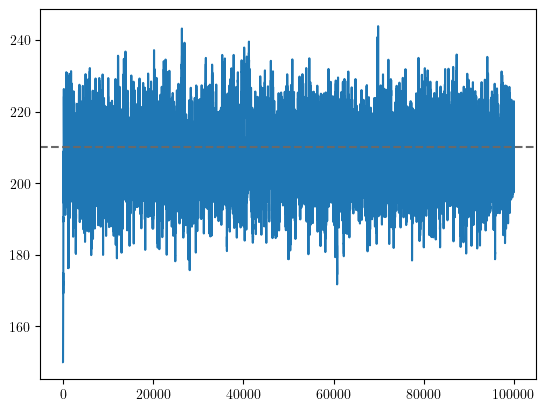

In [14]:
samples, pdf = mh_sampler(
    posterior,
    steps=1e5,
    step_size=2.5,
    init=150,
)
plt.plot(samples)
plt.axhline(E, ls="--", color="dimgray")
# add_labels("Chain", "Sample", "E")

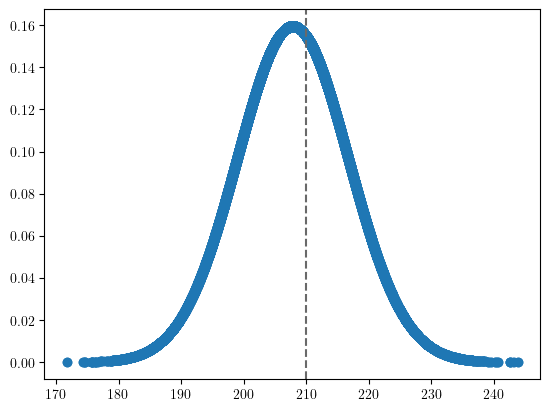

In [15]:
plt.scatter(samples[1000:], pdf[1000:])
plt.axvline(E, ls="--", color="dimgray")
# add_labels("Posterior distribution", "E", "$\pi$")

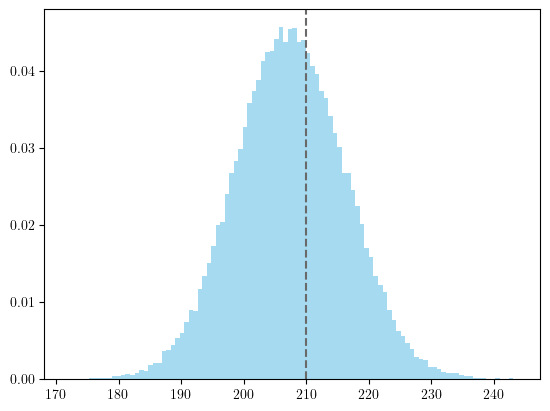

In [16]:
plt.hist(samples[1000:], bins=100, density=True, alpha=0.75, color='skyblue')
plt.axvline(E, ls="--", color="dimgray");

### Maximum a posteriori probability (MAP) estimate

Calculate the maximum a posteriori probability (MAP) point - the point at which the posterior distribution is (globally) maximum

In [17]:
def estimate_map_point(x, pdf, burn=0):
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]

In [18]:
map_point = estimate_map_point(samples, pdf, burn=0)
print("The estimated MAP point is {:.2f} GPa".format(map_point))

The estimated MAP point is 207.85 GPa


### 95% credible region

The 95% credible region is the region that contains 95% of the posterior

In [19]:
def compute_credible_interval(posterior, interval=0.95):
    pass

### 95% prediction interval - Posterior Predictive Distribution??

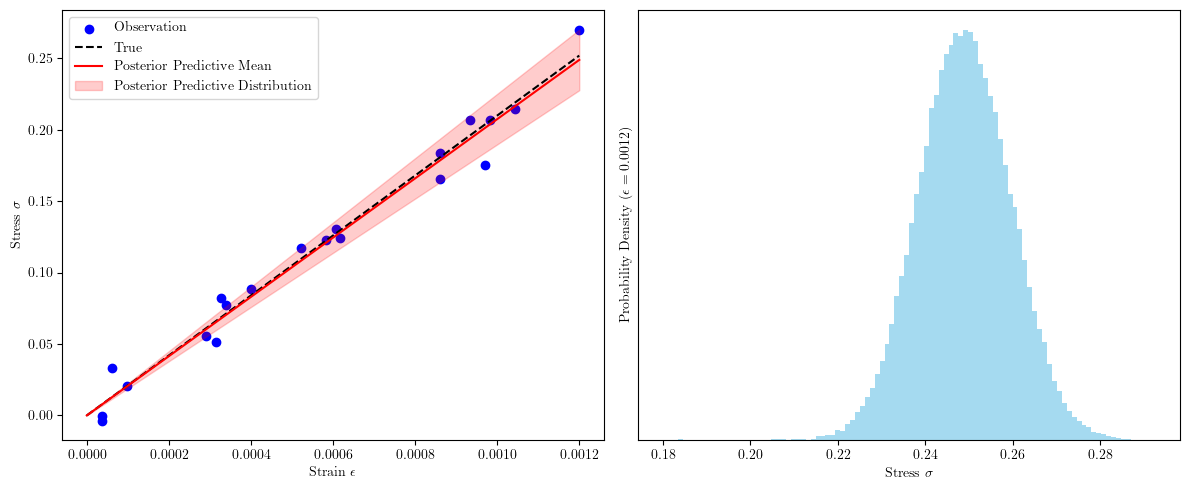

In [20]:
predictions = np.array([compute_stress(sample, strain) for sample in samples])

posterior_predictive_mean = np.mean(predictions, axis=0)
posterior_predictive_std = np.std(predictions, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(strain_observed, stress_observed, color='blue', label='Observation')
ax1.plot(strain, stress, 'k--', label='True')
ax1.plot(strain, posterior_predictive_mean, color='red', label='Posterior Predictive Mean')
ax1.fill_between(strain,
                 posterior_predictive_mean - 2 * posterior_predictive_std,
                 posterior_predictive_mean + 2 * posterior_predictive_std,
                 color='red', alpha=0.2, label='Posterior Predictive Distribution')
ax1.set_xlabel('Strain $\epsilon$')
ax1.set_ylabel('Stress $\sigma$')
ax1.legend()

ax2.hist(predictions[:, -1], bins=100, density=True, alpha=0.75, color='skyblue')
ax2.set_xlabel('Stress $\sigma$')
ax2.set_ylabel('Probability Density ($\epsilon = {}$)'.format(np.max(strain)))
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.tight_layout()

## x. Summary

We will finish by summarising the **Bayesian workflow**:

1. **Define the Problem**: Clearly articulate the problem you are trying to solve or the question you are aiming to answer.

3. **Collect Data**: Gather relevant data that can inform the problem or question at hand.

4. **Likelihood Function**: Establish a mathematical model that describes how the data are related to the parameters of interest. This is known as the likelihood function.

5. **Prior Knowledge**: Gather any existing knowledge or beliefs about the parameters of interest. This is represented as the prior probability distribution.

6. **Bayes' Theorem**: Apply Bayes' theorem, which updates our prior beliefs in light of the observed data, to calculate the posterior probability distribution. Bayes' theorem states that the posterior probability is proportional to the product of the likelihood function and the prior probability.

7. **Posterior Inference**: Analyse the posterior distribution to draw conclusions or make predictions. This might involve calculating summary statistics, credible intervals, or making comparisons between different parameter values.

8. **Validation and Sensitivity Analysis**: Validate the results obtained by checking the model's fit to the data and its sensitivity to changes in assumptions or prior specifications.

9. **Decision Making**: Use the posterior distribution to make decisions or take actions based on the analysis. This could involve choosing the most probable parameter values, making predictions, or assessing the uncertainty associated with different outcomes.

10. **Iterative Process**: Bayesian analysis is often an iterative process, where the model is refined, additional data are collected, and the analysis is updated based on new information.

11. **Communication**: Communicate the results and conclusions effectively, including any uncertainties or assumptions made during the analysis, to stakeholders or decision-makers.

By following these steps, the Bayesian workflow allows for a systematic and principled approach to solving problems and making decisions under uncertainty.